# Image Classification with the Quantum Single Layer Perceptron

This notebook shows how to train and test a custom QML model in a typical Data Science scenario for a image classification problem.

## Dataset

We consider a random sub-sample of the [MNIST dataset](https://it.wikipedia.org/wiki/MNIST_database) of handwritten digits that is usually employed to benchmark different (classical) ML algorithms while spending minimal efforts on preprocessing and formatting. 
As QML model, the [quantum Single Layer Perceptron (or qSLP)](https://link.springer.com/chapter/10.1007/978-3-030-50433-5_45) is adopted. Its implementation (qiskit and pennylane) is available at the following [GitHub](https://github.com/amacaluso/Quantum-Single-Layer-Perceptron).

The reason why only a sub-sample of the original dataset is used is to speed up the computation. In fact,  we need to run the quantum algorithm multiple times for the optimisation process. Using the all dataset is possible but would require a lot of time. 

In [1]:
## Import packages and function
from Utils import *
from Quantum_Operators import *

## Preprocessing

Deep Learning owes its fame to the ability of Neural Networks (NNs) to process and classify successfully unstructured data, like for instance images.  However, Neural Networks do not consider the images directly, but they take as input a numerical representation of it; this means that before running an image through a NN, it is necessary to transform it to generate its numerical representation. We follow the same approach for Quantum Neural Networks.

Data features shape: (60000, 28, 28)
Data labels shape: (60000,)


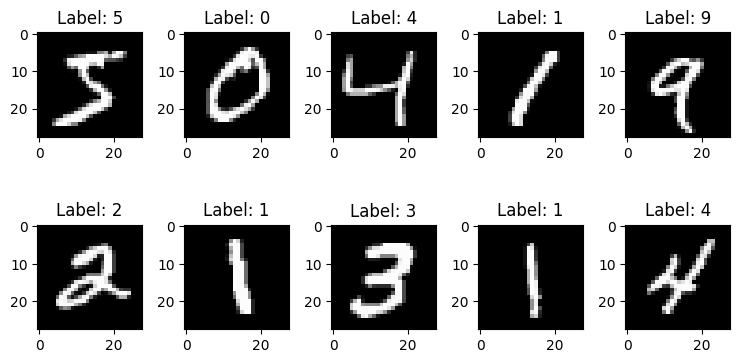

In [2]:
# load MNIST dataset
from keras.datasets import mnist
(x_raw, y_raw), _ = mnist.load_data()

print('Data features shape:', x_raw.shape)
print('Data labels shape:', y_raw.shape)

# plot images
num_row = 2; num_col = 5 
# num_row x num_col gives the total number of images that will be plotted

# The function plot_images (Utils.py) takes as input the 
# matrix representation of the images and visualise them
plot_images(x_raw, y_raw, num_row, num_col)

The current implementation of the qSLP solves a binary classification problem.
Thus, we need to consider only two classes. We will select the digits 0 and 9 but it is possible to change the two classes to train the model in distinguishing different handwritten digits.

In [3]:
# Classes of interest. The QML model will be trained to distinguisg between 0 and 9
class0, class1 = 0,9

# Select all the images that belong to the selected classes
ix = np.where((y_raw == class0) | (y_raw == class1)) 
x_raw, y_raw =x_raw[ix], y_raw[ix]

In [4]:
# We consider only a sub-sample of 200 observations (100 per class) 
# that will be splitted into training and test set

# seed to reproduce the results
seed=123

# set seed
np.random.seed(seed)

# number of observation for each class
n = 100

# Generate a new dataset composed by only 100 observations
# for each class of interest
mask = np.hstack([np.random.choice(np.where(y_raw == l)[0], n, replace=False)
                      for l in np.unique(y_raw)])
random.shuffle(mask)
x_raw, y_raw =x_raw[mask], y_raw[mask]

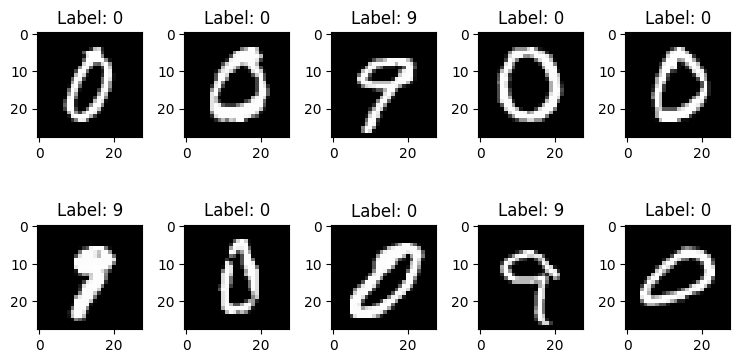

In [5]:
# Visualise the first 10 observations of the new dataset
plot_images(x_raw, y_raw, num_row, num_col)

At this point we have the final dataset that will be used to train the QML model.

We split the whole dataset in training and test set. The model will be trained using QASM simulator and the predictions for the test set will be computed using both QASM simulator and fake real device.

In [6]:
# The size in percentage of data the training set
train_size = 0.90 #200 x 0.9 = 180 training observations

# Random splitting of dataset in training and test
num_data = len(y_raw)
num_train = int(train_size * num_data)
index = np.random.permutation(range(num_data))

# Training set
X_train = x_raw[index[:num_train]]
Y_train = y_raw[index[:num_train]]

# Test set
X_test = x_raw[index[num_train:]]
Y_test = y_raw[index[num_train:]]

# The variable ncol stores the total number of pixels to represent the images
ncol = x_raw.shape[1]*x_raw.shape[2]

# We construct the dataset where each row represents an image each column a pixel 
x_flat = X_train.reshape(-1,ncol)

print(x_flat.shape) #(180, 784)
# We have 180 images in the training set described by 784 pixels

# Rename the columns
feat_cols = ['pixel'+str(i) for i in range(x_flat.shape[1])]

# construction of the pandas dataframe
df_flat = pd.DataFrame(x_flat,columns=feat_cols)
df_flat['Y'] = Y_train

# Visualise the first 5 rows of the dataset
df_flat.head()

(180, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The current implementation of the qSLP considers only two-input features, then we need to reduce the number of features while keeping as much as possible the representativity of data. To this end, the [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) is employed to represent the images using a $2$-dimensional vector, which results from the linear combination of the initial $784$ features. 
Notice that we do not use any information about the class label since the PCA is an unsupervised learning method. Furthermore, once the coefficients to compute the new features are estimated, it is possible to apply the PCA to new data points without any prior information on the target variable.

In [7]:
# From sklearn.decomposition we import the class PCA that allows performing the Principal Component Analysis

# Two principal components are considered
pca = PCA(n_components=2) 

# Application of the PCA to the dataset
principalComponents = pca.fit_transform(x_flat) 
print('The size of the new dataset (no label) is :', principalComponents.shape)

The size of the new dataset (no label) is : (180, 2)


In [8]:
sum(pca.explained_variance_ratio_)

0.3078193607976508

We create a new dataset where the images are represented by a two-dimensional vector that corresponds to the first two principal components.

In [9]:
data_pca = pd.DataFrame(data = principalComponents, 
                        columns = ['Component '+str(i+1) for i in range(principalComponents.shape[1])])

# Append the target variable to the new dataset
data_pca['Y'] = df_flat.iloc[:,-1:].to_numpy()

# Visualise the first 5 rows of the new dataset
data_pca.head()

,Component 1,Component 2,Y
0,-946.410635,-634.214181,9
1,-506.559034,-487.947177,9
2,-1008.889316,171.392375,9
3,-1071.035136,-633.391347,9
4,877.232005,169.949747,0


At this point, each row is represented by a two-dimensional vector and the value of the target variable, that are all the information needed to train the qSLP.

## Data Visualisation

<Axes: xlabel='Component 1', ylabel='Component 2'>

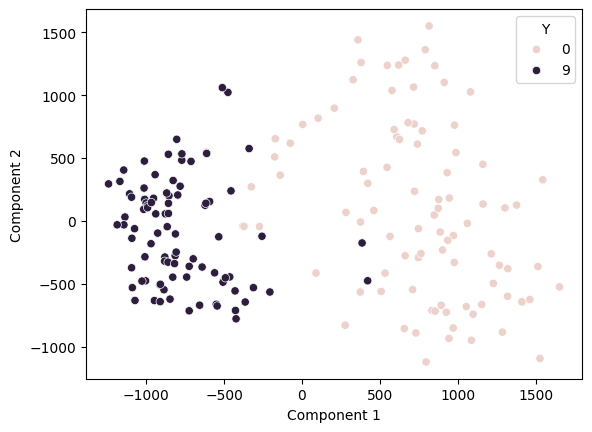

In [10]:
# scatter plot of the new representation
cols=["Component 1", "Component 2"]
sns.scatterplot(x=cols[0], y=cols[1], hue="Y", data=data_pca, legend="full")

Data will be encoded in *amplitude encoding*, which means that the amplitudes of a quantum state will encode the values of the features. This implies that each image has to be represented by a normalised vector. 

In [11]:
# Extract the new feature as numpy array
x_pca = data_pca[cols].to_numpy()

MAX=np.max(x_pca)
MIN=np.min(x_pca)

# Rescaling of the values of the features
X = (x_pca-MIN)/(MAX-MIN)
Y = data_pca.Y.to_numpy()

### Python UDF for State Preparation

We pad the $2$-dimensional vector using constant values, the same approach is used in [this pennylane tutorial](https://pennylane.readthedocs.io/en/user-docs-refactor/tutorials/pennylane_run_variational_classifier.html#variational-classifier). Also, the qSLP requires $6$ parameters for each quantum hidden neuron and $1$ for the linear combination of the output layer. Thus, in total we have $6 \times 2 + 1 = 13$ parameters.

In [12]:
# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T

# angles for state preparation are new features
features = np.nan_to_num((np.array([get_angles(x) for x in X_norm])))

# number of parameters for each layer
n_param_L = 6

# total number of parameters
n_parameters = n_param_L*2+1

# We define our training set, that will be the input of our QML model
X_train = features.copy()
Y_train = (Y-class0)/(class1-class0)

## Modeling: Training the quantum Single Layer Perceptron (qSLP)

A qSLP  generates a weighted average of two linear combination of the same input data $x$ in superposition, each one parametrised by a different set of parameters $\theta_j$, entangled with a control register. The entanglement between control and data register is controlled by a set of $\beta$ parameter. The qSLP allows to access the model prediction by single-qubit measurement. All the details about the algorithm are provided in the [original paper](https://link.springer.com/chapter/10.1007/978-3-030-50433-5_45). Here, we report the quantum circuit and the final output state:

### Quantum Circuit

<a id='qSLP_circuit'></a>

<p align="center">
  <img width="500" height="150" src="qSLP.JPG">
</p>

### Output quantum state:

<p align="center">
<img src="https://latex.codecogs.com/svg.latex?\Large&space;\frac{1}{\sqrt{E}}\Big(\beta_1|0\rangle|\sigma_{hid}\big[L(x;\theta_1)\big]\rangle|\phi\rangle+\beta_2|1\rangle|\sigma_{hid}\big[L(x;\theta_2)\big]\rangle|\phi\rangle\Big)"/>
</p>

where $E$ is a normalization constant to ensure a normalized quantum state. 

This is the quantum version of a two-layer single layer neural network (see the [paper](https://link.springer.com/chapter/10.1007/978-3-030-50433-5_45) for more details). 

We can see that we need to define four types of gates: $R_Y(\beta)$, $S_x$, $G(\theta_i)$ and $\Sigma$. These gates are defined as follows.

### State Preparation: Gate $S_x$

The original features are padded with constant values and encoded according to the scheme described in [Möttönen et al. (2004)](https://arxiv.org/abs/quant-ph/0407010). The function $get\_S_{x}$ takes as input $5$ real values that are the 5 rotation angles of the rotation operato $(R_Y)$ and generates the quantum circuit to encode the specific real input into a quantum state (more details in the python script Quantum_Operators.py). 

Notice that, it is possible also to employ the function [qiskit.extensions.Initialize](https://qiskit.org/documentation/stubs/qiskit.extensions.Initialize.html) to encode a normalized real $n$-dimensional vector into $log_2n$ qubits (in this case it is necessary to set the option *pad=False*).

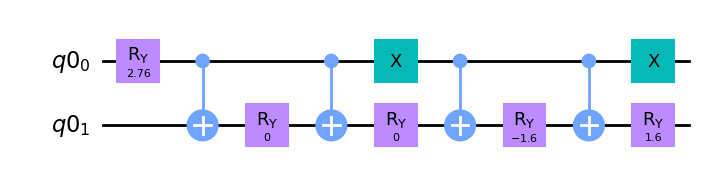

In [13]:
gate = get_Sx(ang=features[1], x=None, pad=True, circuit=True)
gate.draw('mpl')

### Hidden Layer - Linear operator: Gate $G(\theta_i)$

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$

Once the quantum state $\ket{x}$ is generated, we have to perform $2$ linear transformations of this quantum state based on two different sets of parameters $(\theta_1, \theta_2)$. The gate $G$ is embedded in the function *linear_operator* which has the following form:

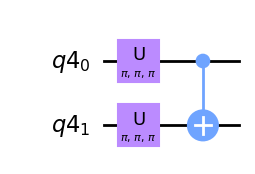

In [14]:
# linear_operator needs to be inisialised by defining a set of parameters
parameters = np.repeat(np.pi, n_param_L)
G = linear_operator(parameters, pad=True, circuit=True)
# padded variables regulate the size of the input vector. If pad=yes, a normalised four-dimensional real vector is assumed
# the variable 'circuit=True' set out whether the function outputs the unitary matrices or the quantum circuit

G.draw('mpl')

$G(\theta_i)$ transform the input data by applying a parametrised unitary operation as follows:

$$\ket{x} \xrightarrow{G(\theta_i)} \ket{L(x;\theta_i)}$$

### Output Layer: Gate $R_Y(\beta)$

Gate $R_Y(\beta)$ is the single-qubit rotation about the $Y$ axis. It transforms the control quibt into a non uniform superposition based on parameter $\beta$.

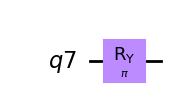

In [15]:
R=R_gate(np.pi, circuit=True)
R.draw('mpl')

### Activation function: gate $\Sigma$

Ideally, we would need a proper activation function that working via interference transforms a given linear combination using a non-linear activation function. Since, as far as we know, there is no such gate we use a simple identity function as $\Sigma$ gate.

Note: an attempt to approximate non-linear activation function using fault-tolerant quantum computation is given in this paper Quantum Splines [[3]](#3). [Here](#4) the implementation.

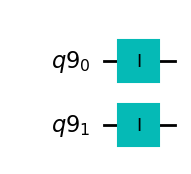

In [16]:
s=sigma(pad=True, circuit=True)
s.draw('mpl')

### Qiskit implementation of the qSLP

Now we have all the ingredients to build the quantum circuit for the qSLP. All the following steps aim to train a parametrised quantum algorithm to discriminate digits 0 and 9 of the MNIST dataset. 

In order to visualise in qiskit the whole of the [qSLP](#qSLP_circuit) we encoded the four gates using ad-hoc unitary matrices.

In [17]:
# The following function creates a quantum circuit that takes as  
# input the input features x and the set of parameters

def create_circuit_compact(parameters=None, x=None, pad=True):
    
    # Total number of parameters in the quantum circuit
    n_params=len(parameters)
    
    # Parameters of quantum gates for control, data and temp register
    beta = parameters[0]
    theta1 = parameters[1:int((n_params+1)/2)]
    theta2 = parameters[int((n_params+1)/2):int(n_params)]
    
    #Initialization of the quantum circuit
    control = QuantumRegister(1, 'control')
    data = QuantumRegister(2, 'data')
    temp = QuantumRegister(2, 'temp')
    c = ClassicalRegister(1)
    qc = QuantumCircuit(control, data, temp, c)

    ### STATE PREPARATION
    
    # Encode data into a quantum state 
    S=get_Sx(ang=x, x=None, pad=pad)
    qc.unitary(S, data, label='$S_{x}$')
    
    # Initialisation of the control qubit
    R=R_gate(beta)
    qc.unitary(R, control, label='$R_{Y}(β)$')

    qc.barrier()
    
    
    ### LINEAR TRANSFORMATIONS IN SUPERPOSITION
    
    # cswap between data and temp register
    qc.cswap(control, data[0], temp[0])
    qc.cswap(control, data[1], temp[1])

    
    # Apply quantum gate G(ϴ) to the data register
    G1 = linear_operator(theta1, pad)
    qc.unitary(G1, data, label='$G(θ_{1})$')
    
    # Apply quantum gate G(ϴ) to the temp register
    G2 = linear_operator(theta2, pad)
    qc.unitary(G2, temp, label='$G(θ_{2})$')
    
    
    
    # cswap between data and temp register
    qc.cswap(control, data[1], temp[1])
    qc.cswap(control, data[0], temp[0])

    qc.barrier()
    
    
    ### SINGLE EXECUTION OF THE ACTIVATION FUNCTION

    sig = sigma(pad)
    qc.unitary(sig, data, label='$Σ$')
    
    qc.barrier()
    
    ### MEASUREMENT
    
    qc.measure(data[0], c)
    return qc

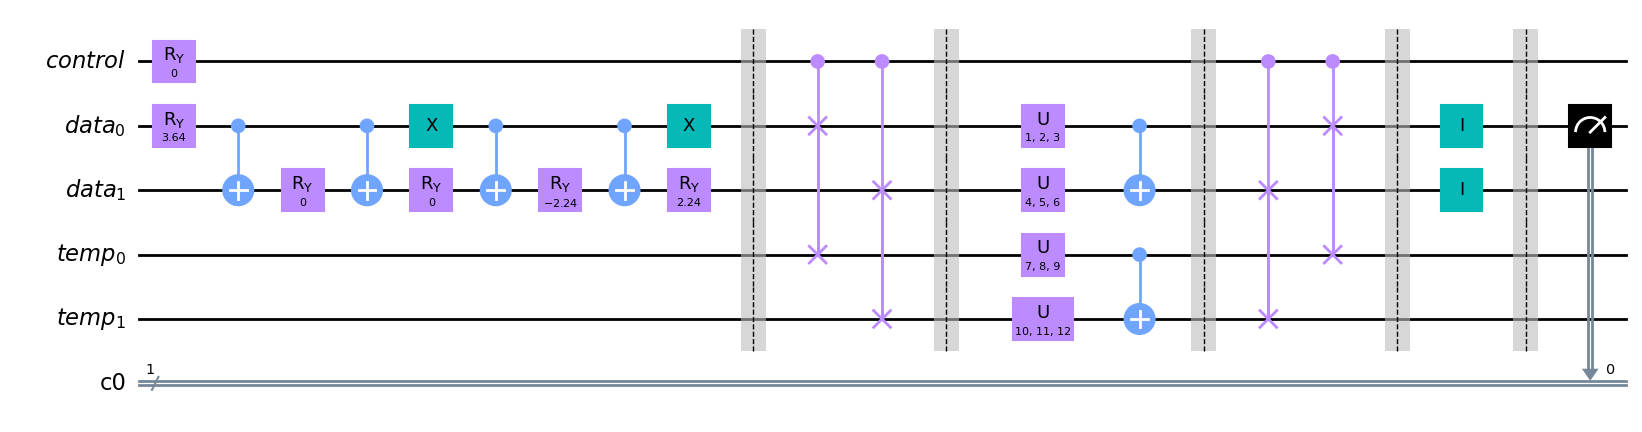

In [18]:
qc=create_circuit(parameters=range(n_parameters+1), x=features[0])
qc.draw(output='mpl')

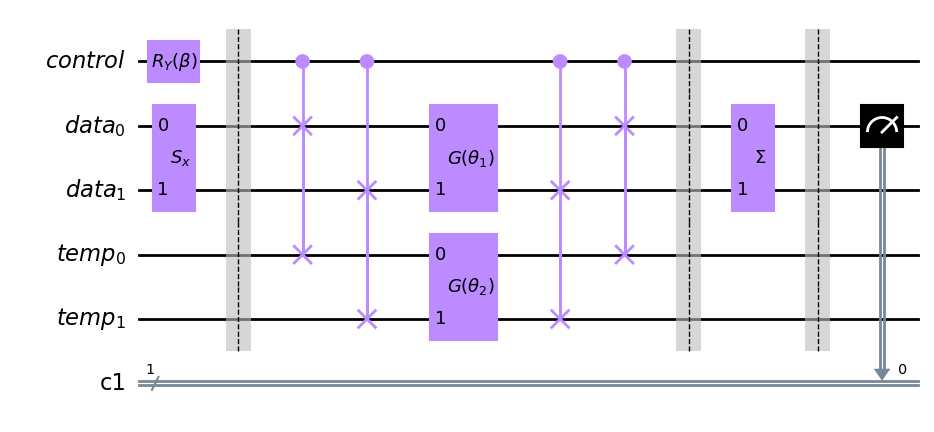

In [19]:
# Plot the specific qSLP using qiskit. In order to be able to call 
# the function we need to give some value for parameters and x

qc=create_circuit_compact(parameters=range(n_parameters+1), x=features[0])
qc.draw(output='mpl')

#### Transpiling the quantum circuit

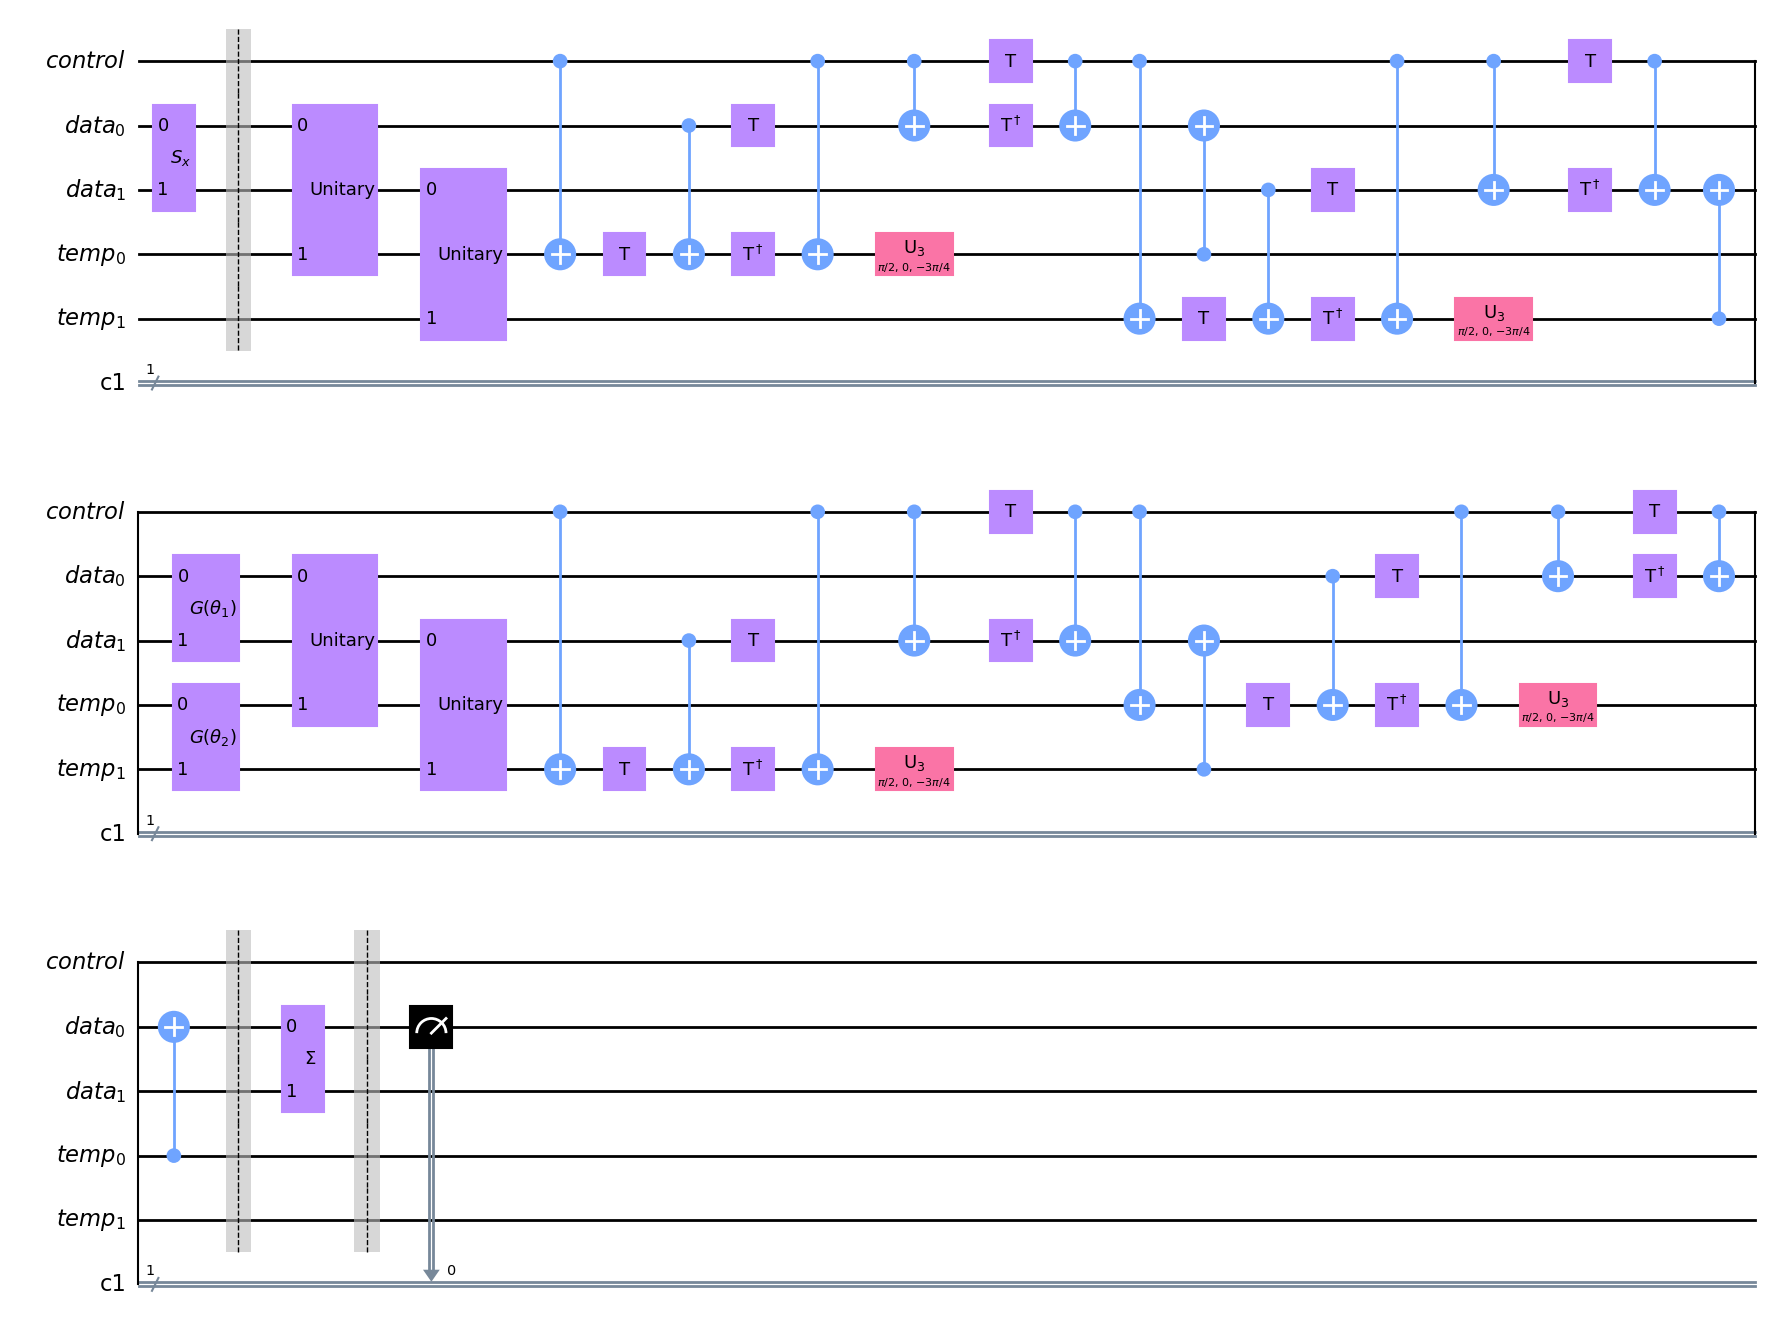

In [20]:
from qiskit.compiler import transpile
qc = transpile(qc, optimization_level=3)
qc.draw(output='mpl')

Once we have the function to generate the qSLP, it is necessary to define other two functions that execute the quantum circuit given a specific set of parameters and evaluate the cost of the prediction in terms of binary crossentropy. In particulare, the function *cost* computes the binary crossentropy between the predicted values by the qSLP and the actual values of the target variable.

In addition, we need to initialise randomly the set of parameters of the quantum circuit to begin the optimisation process.

In [21]:
def execute_circuit(parameters, x=None, shots=1000, print=False, backend=None):
    if backend is None:
        backend = BasicAer.get_backend('qasm_simulator')

    circuit=create_circuit(parameters, x)
    if print:
        circuit.draw(output='mpl')
        plt.show()
    result = execute(circuit, backend, shots=shots).result()

    counts = result.get_counts(circuit)
    result = np.zeros(2)
    for key in counts:
        result[int(key, 2)] = counts[key]
    result /= shots
    return result[1]

def cost(params, X, labels):
    predictions = [execute_circuit(params, x) for x in X]
    return binary_crossentropy(labels, predictions)

In [22]:
# Parameter initialisation
init_params = (np.repeat(1, n_parameters))
print(init_params)

[1 1 1 1 1 1 1 1 1 1 1 1 1]


#### Run the model with random parameters

In [23]:
# Compute the prediction of the randomly intialised qSLP for the observations in the training set
probs_train = [execute_circuit(init_params, x) for x in X_train]

# Given the probabilities for the two classes, that are computed as the two basis states 
# of the first qubit of the data register, the function 'predict' computes the predicted class
# of the target variable
predictions_train = [predict(p) for p in probs_train]

# Once we have the true and the predicted classes we can compute 
# the accuracy and the cross entropy (loss) of the model given the initial parametrisation

# accuracy
acc_train = accuracy(Y_train, predictions_train)

#loss
loss = cost(init_params, X_train, Y_train)
        
print("Random: | Cost: {:0.7f} | Acc train: {:0.3f}" "".format(loss, acc_train))

Random: | Cost: 0.2667444 | Acc train: 0.533


Using a random inisialitasion (all parameters equal to $\pi$) of the quantum circuit our model perform with $50\%$ of accuracy.

## Optimisation

The goal of the optimisation process is to find the best parameters for the specific dataset. The whole process is the following: the single data point $x$ is encoded into a quantum state $\ket{x}$ and the qSLP computes the prediction given a specific set of parameters. This is performed using all the data points in the training set. 
Thus, a cost for the current parametrisation is computed and the parameters of the quantum circuit are updated as many time as the number of epochs. Then, the whole cycle is run multiple times in a closed loop between the classical and quantum simulation.

At the end of this process we have the best set of parameters to predict the label with our QML model!

Notice that to speed up the computation, each epoch considers only a fixed number of observations (*batch_size*).

In [24]:
batch_size = 10
epochs = 10
acc_final_tr = 0 

from scipy.optimize import minimize

# define the optimiser
# optimizer_step = COBYLA(maxiter=10, tol=0.01, disp=False)

# define the initial set of parameters
point=init_params

#optimisation
for i in range(epochs):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.3f}"
        "".format(i + 1, cost(point, X_train, Y_train), acc_train))
    
    obj_function = lambda params: cost(params, X_batch, Y_batch)
    # point, value, nfev = optimizer_step.minimize(len(point), obj_function, initial_point=point)
    point = minimize(obj_function, point, method='COBYLA', options={'maxiter': 10}).x
    
    # Compute predictions on train and validation set
    probs_train = [execute_circuit(point, x) for x in X_train]
    # probs_val = [execute_circuit(point, x) for x in X_val]

    predictions_train = [predict(p) for p in probs_train]
    # predictions_val = [predict(p) for p in probs_val]

    acc_train = accuracy(Y_train, predictions_train)
    # acc_val = accuracy(Y_val, predictions_val)

    if acc_final_tr <= acc_train:
        best_param = point
        acc_final_tr = acc_train
        # acc_final_val = acc_val
        iteration = i

Iter:     1 | Cost: 0.2647571 | Acc train: 0.533
Iter:     2 | Cost: 0.1643904 | Acc train: 0.933
Iter:     3 | Cost: 0.1249855 | Acc train: 0.917
Iter:     4 | Cost: 0.1245916 | Acc train: 0.911
Iter:     5 | Cost: 0.1254546 | Acc train: 0.917
Iter:     6 | Cost: 0.1231571 | Acc train: 0.917
Iter:     7 | Cost: 0.1243761 | Acc train: 0.911
Iter:     8 | Cost: 0.1241747 | Acc train: 0.917
Iter:     9 | Cost: 0.1244705 | Acc train: 0.922
Iter:    10 | Cost: 0.1236011 | Acc train: 0.906


**We have a final model!**

We can observe that $10$ epochs are enough to achieve good performance. This means that the task is not particularly difficult to solve for the qSLP. In fact, if looking at the new representation of the images, the pattern recognition problem can be efficiently solved using a linear model. The maximum training accuracy is around $80\%$.

As in classical ML, we need to consider the error of the model in a separate unseen set of data. However, in order to estimate the generalisation error, we need to preprocess the original features of the test using the PCA and normalisation described above.

We will compute the predictions for the test set using QASM simulator and real device.

### Model Testing on QASM simulator

Before running the images in the test set throgh the qSLP it is necessary to map the original feature space into the normalised feature space generated by the PCA. The function *image_reshape* performs this task,

In [25]:
# The function image_reshape maps the representation of an image based on the 784 pixels
# into a two-dimensional representation

X_test_scaled = np.array([image_reshape(x, ncol, pca, MIN, MAX) for x in X_test])
Y_test_scaled = (Y_test-class0)/(class1-class0)

In [26]:
# Compute the predicted probability for the test set
probs_test = [execute_circuit(best_param, x, shots=8192) for x in X_test_scaled]

# Extract the predicted classes
predictions_test = [predict(p) for p in probs_test]

# compute the accuracy and the cost for the test set
acc_test = accuracy(Y_test_scaled, predictions_test)

print("Final model - Performance on test set \n Cost: {:0.7f} | Acc validation: {:0.5f} "
      "".format(cost(best_param, X_test_scaled, Y_test_scaled), acc_test))

Final model - Performance on test set 
 Cost: 0.2171252 | Acc validation: 0.95000 


The test accuracy is $95\%$.

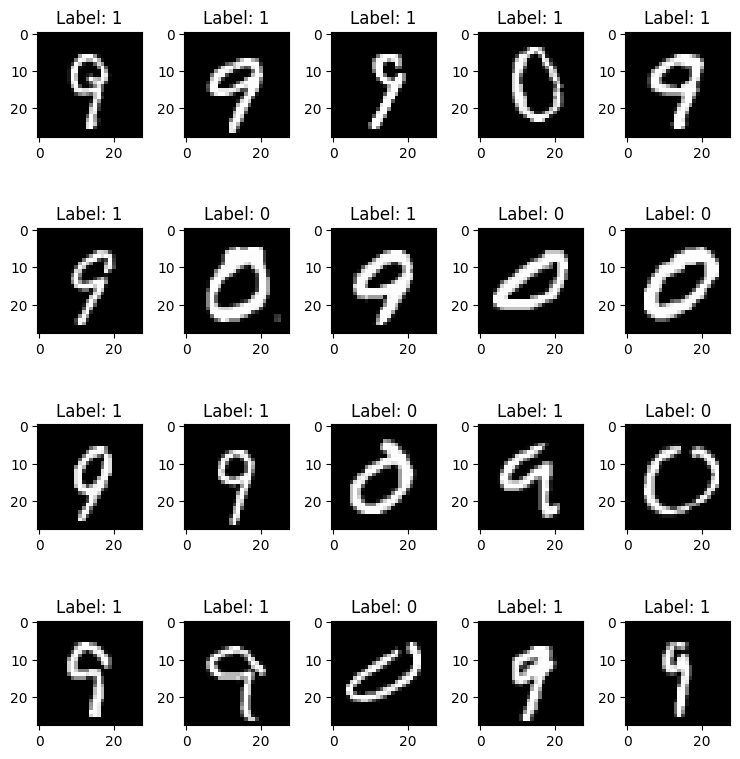

In [27]:
# Plot the images with the correspondent predicted class
num_row = 4
num_col = 5

# plot images
plot_images(X_test, predictions_test, num_row, num_col)

We can see that $2$ up to $20$ observations (exactly the $85\%$) are misclassified.

### Testing on (fake) real device

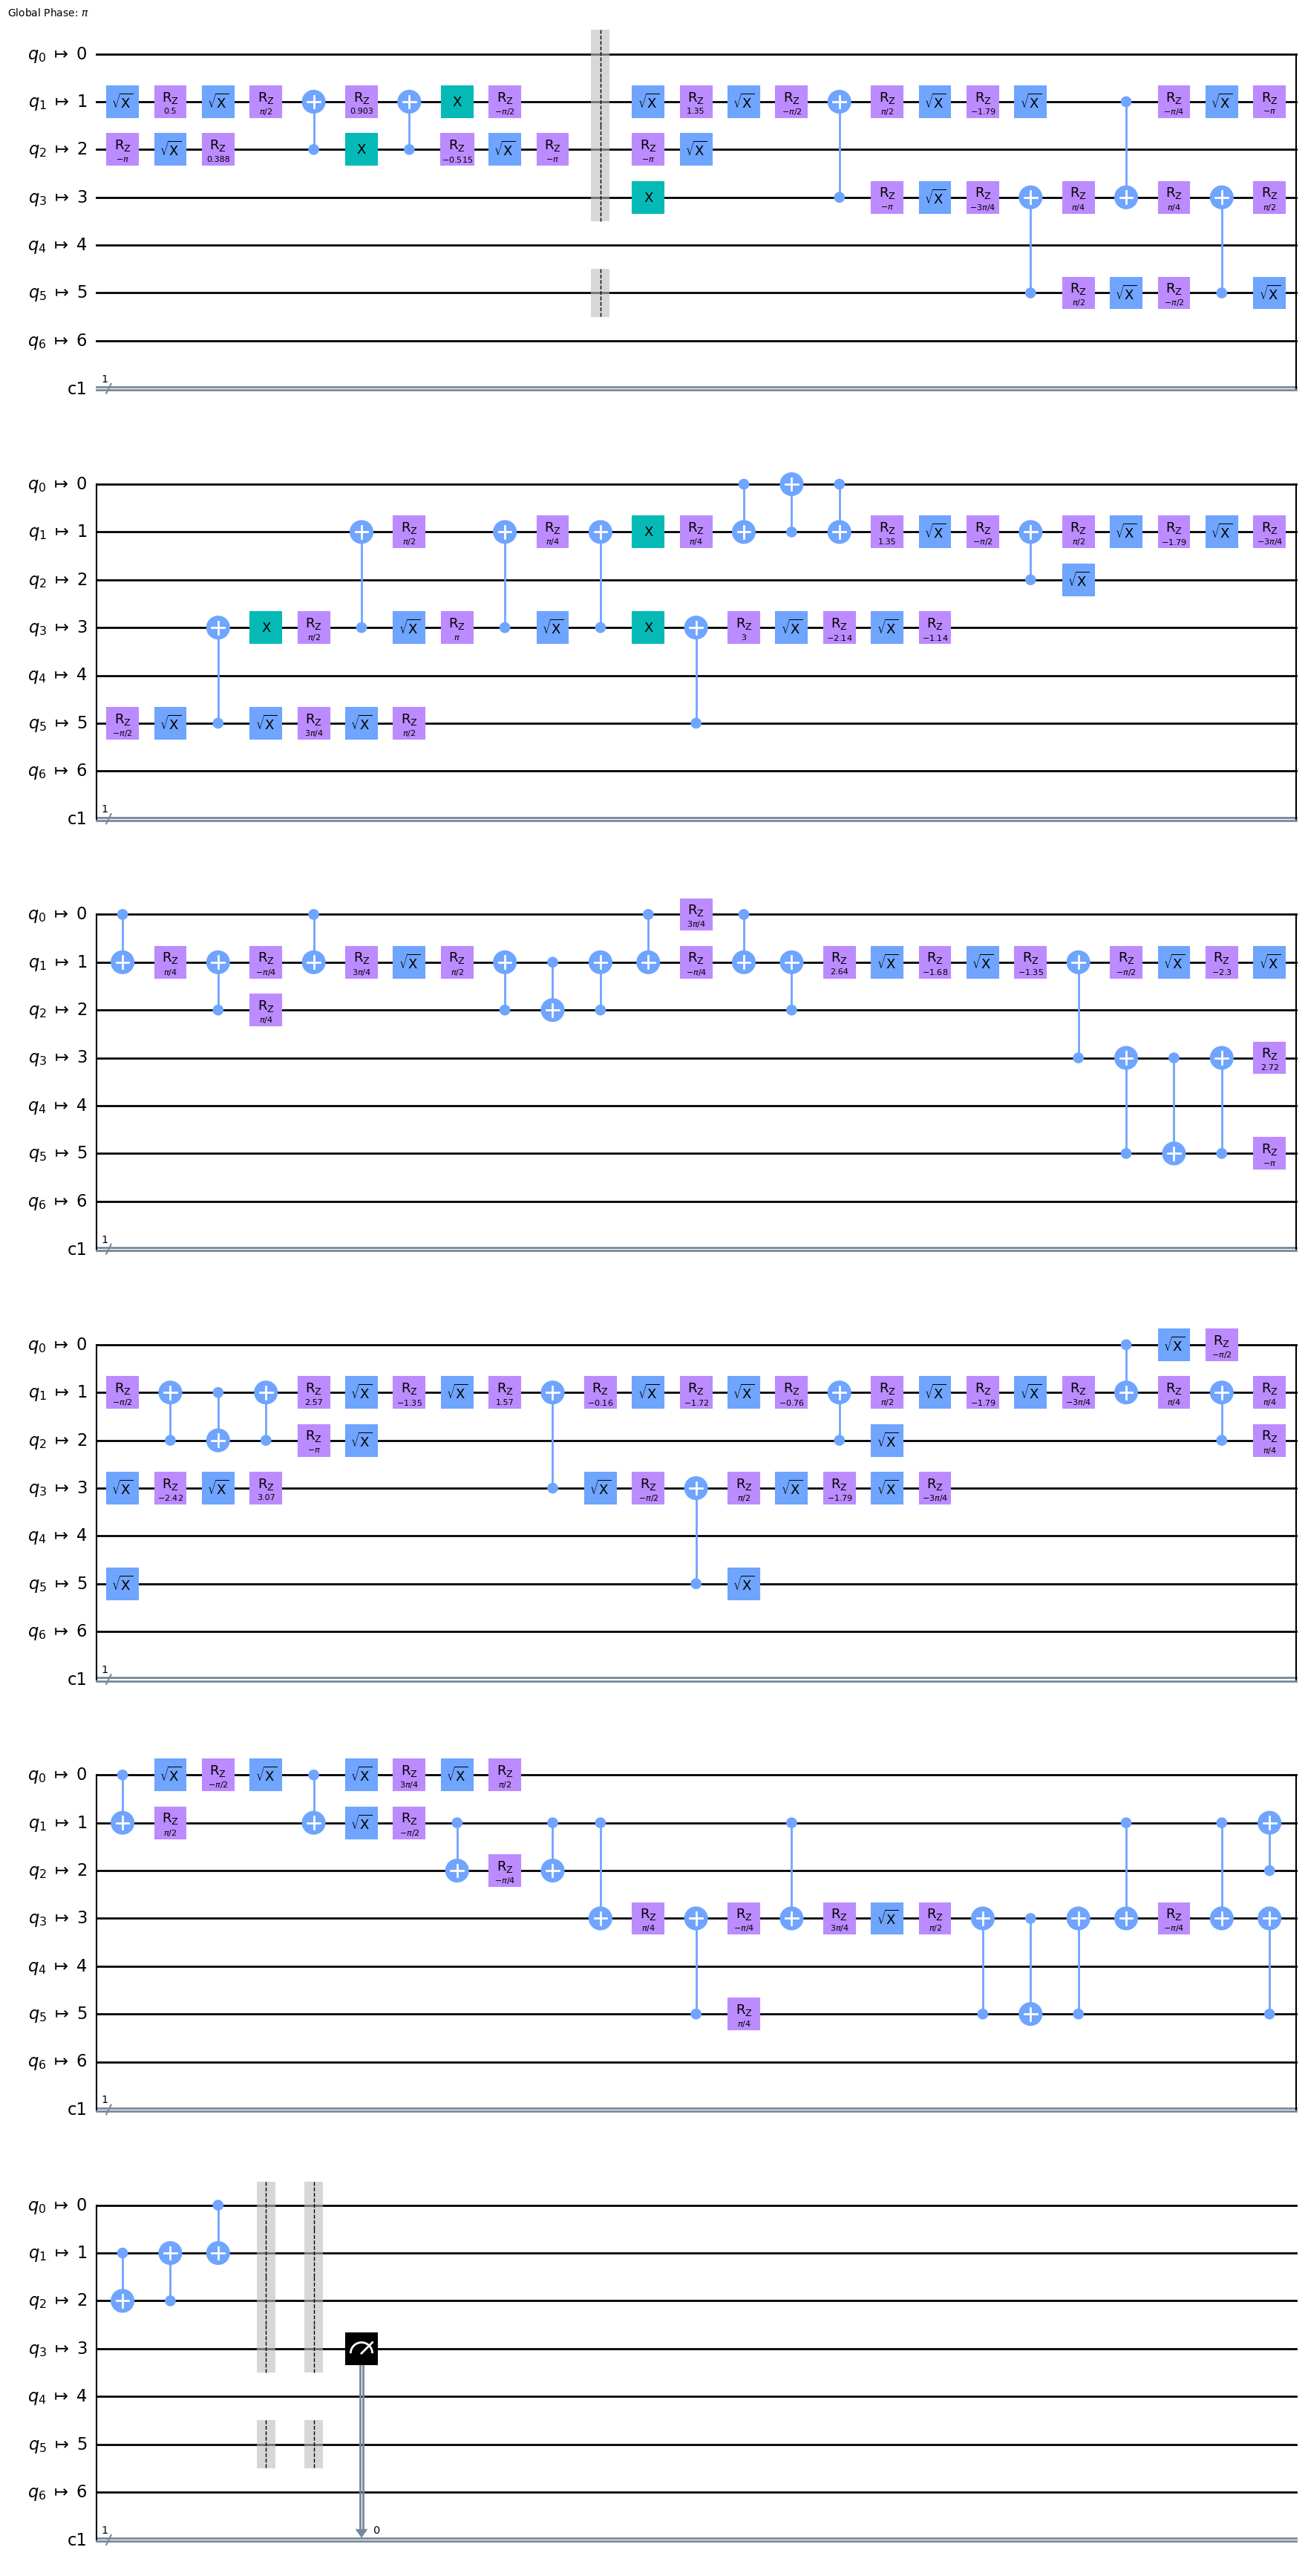

In [32]:
from qiskit.providers.fake_provider import FakeManila, FakeLagos

# Make a noise model
# fake_backend = FakeManila()
fake_backend = FakeLagos()
qc = transpile(qc, backend=fake_backend, optimization_level=3)
qc.draw(output='mpl')

In [29]:
probs_test = [execute_circuit(point, x, shots=8192, backend=fake_backend) for x in X_test_scaled]

In [30]:
predictions_test = [predict(p) for p in probs_test]

acc_test = accuracy(Y_test_scaled, predictions_test)

print("Final model: Cost: {:0.7f} | Acc validation: {:0.5f} "
      "".format(cost(best_param, X_test_scaled, Y_test_scaled), acc_test))

Final model: Cost: 0.2096156 | Acc validation: 0.95000 


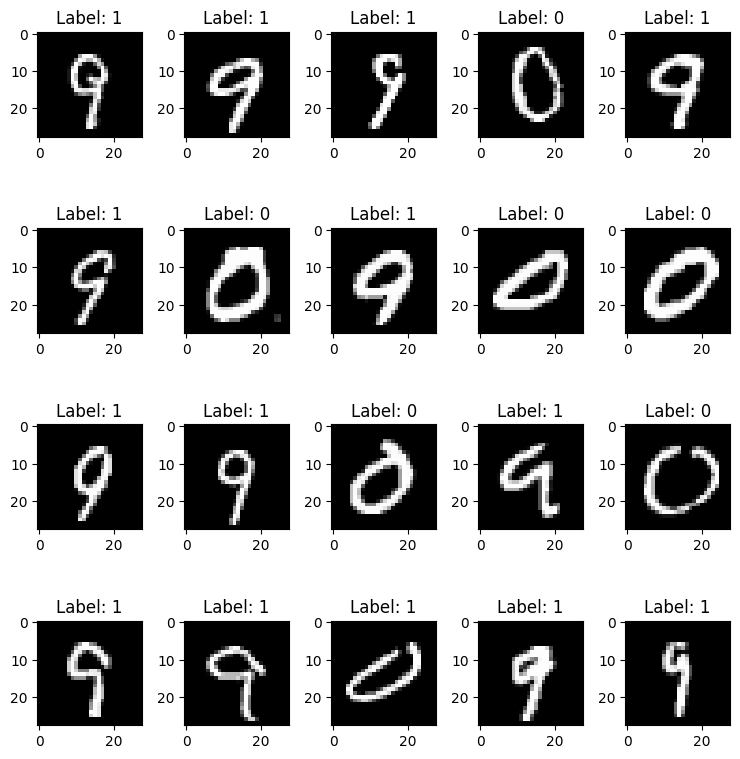

In [31]:
num_row = 4
num_col = 5

# plot images
plot_images(X_test, predictions_test, num_row, num_col)

We can observe a deterioration in terms of accuracy when computing the prediction on real device. 

However, 
**the trained qSLP is still able to classify correctly the $80\%$ of the images!**

## Conclusion

We solved an image classification problem using the quantum version of a two-neuron Quantum Single Layer Neural Network[1]. 

We have seen that, even for dataset with large input feature space, it is possible apply classical unsepervised methods to test the QML model and understand if a given quantum circuit can work as ML model. Importantly, any dataset can be used to test the qSLP. Furthermore, if one needs to test another quantum circuit for a similar task it is enough to edit the function that creates the quantum circuit and use the same notebook!

## References
<a id="1">[1]</a> 
 Macaluso et al. "A Variational Algorithm for Quantum Neural Networks." *International Conference on Computational Science.* Springer, Cham, 2020.

<a id="2">[2]</a> 
https://github.com/amacaluso/Quantum-Single-Layer-Perceptron